In [1]:
import pickle
import os
import numpy as np

In [2]:
from quchem_ibm.exp_analysis import *

def dict_of_M_to_list(M_dict, PauliOP):
    
    P_Qubit_list, _ = zip(*(list(*PauliOP.terms.keys())))
    
    list_of_M_bitstrings=None
    for bit_string, N_obtained in M_dict.items():
        
        M_string = np.take(list(bit_string[::-1]), P_Qubit_list) # only take terms measured! Note bitstring reversed!
        
        array_meas = np.repeat(''.join(M_string), N_obtained)
        if list_of_M_bitstrings is None:
            list_of_M_bitstrings=array_meas
        else:
            list_of_M_bitstrings=np.hstack((list_of_M_bitstrings,array_meas))
    
    # randomly shuffle (seed means outcome will always be the SAME!)
    np.random.seed(42) 
    np.random.shuffle(list_of_M_bitstrings) 
    
    return list_of_M_bitstrings

In [3]:
# # input for exp
base_dir = os.getcwd()
input_file = os.path.join(base_dir, 'LiH_simulation_RESULTS_time=2020Oct07-163210198971.pickle')
with open(input_file, 'rb') as handle:
    LiH_data = pickle.load(handle)


In [4]:
experimental_data_SEQ_ROT = LiH_data['experiment_data'].copy()

del LiH_data

In [5]:
SEQ_ROT_data = experimental_data_SEQ_ROT[101852100]['seq_rot'].copy()
del experimental_data_SEQ_ROT


In [6]:
SEQ_ROT_Hist_data_sim={}
    
for exp_instance in SEQ_ROT_data: 
    for exp_dict_key in exp_instance:

        exp_dict= exp_instance[exp_dict_key]

        if 'Ps' in exp_dict.keys():
            P=exp_dict['Ps']
            coeff = exp_dict['gamma_l']

            measured_dict_sim = exp_dict['measurement_dict']

        else:
            P=exp_dict['qubitOp']
            coeff = exp_dict['coeff']
            measured_dict_sim = exp_dict['measurement_dict']

        M_list_sim = dict_of_M_to_list(measured_dict_sim, P)

        if exp_dict_key in SEQ_ROT_Hist_data_sim.keys():
            SEQ_ROT_Hist_data_sim[exp_dict_key]={'P':P ,'coeff': coeff, 'Measurements': np.hstack((SEQ_ROT_Hist_data_sim[exp_dict_key]['Measurements'],M_list_sim))}
        else:
            SEQ_ROT_Hist_data_sim[exp_dict_key]={'P':P ,'coeff': coeff, 'Measurements': M_list_sim}


In [7]:
SEQ_ROT_Hist_data_sim[0]['Measurements'].shape

(9985500,)

In [8]:
# ### save output
# np.save('LCU_hist_data', STANDARD_Hist_data_sim)

In [9]:
import matplotlib.pyplot as plt

In [10]:
# i_list_XY=[]
# SEQ_ROT_Hist_data_XY={}

# i_list_Z=[]
# SEQ_ROT_Hist_data_Z={}
# amplitude_min=0

# for key in SEQ_ROT_Hist_data_sim:
#     Pword, const = SEQ_ROT_Hist_data_sim[key]['P']
#     coeff=SEQ_ROT_Hist_data_sim[key]['coeff']
    
#     if np.abs(coeff)>amplitude_min:
#         qubitNos, qubitPstrs = zip(*(list(Pword)))
#         # XY terms only!
#         if ('X' in qubitPstrs) or ('Y' in qubitPstrs):
#             i_list_XY.append(key)
#             SEQ_ROT_Hist_data_XY[key]=SEQ_ROT_Hist_data_sim[key]
#         else:
#             i_list_Z.append(key)
#             SEQ_ROT_Hist_data_Z[key]=SEQ_ROT_Hist_data_sim[key]

In [12]:
i_list_XY=list(range(2,102))
SEQ_ROT_Hist_data_XY={}

i_list_Z=[0,1]
SEQ_ROT_Hist_data_Z={}
amplitude_min=0

for key in i_list_XY:
    SEQ_ROT_Hist_data_XY[key]=SEQ_ROT_Hist_data_sim[key]

for key in i_list_Z:
    SEQ_ROT_Hist_data_Z[key]=SEQ_ROT_Hist_data_sim[key]

In [ ]:
fci_energy= -7.971184315565538

# Histogram

In [14]:
from tqdm.notebook import tqdm
def Get_Hist_data(Histogram_data, I_term):
    E_list=[]
    for m_index in tqdm(range(Histogram_data[list(Histogram_data.keys())[0]]['Measurements'].shape[0])):
        E=I_term
        for M_dict_key in Histogram_data:
            coeff = Histogram_data[M_dict_key]['coeff']
            parity =  1 if sum(map(int, Histogram_data[M_dict_key]['Measurements'][m_index])) % 2 == 0 else -1
            E+=coeff*parity
        E_list.append(E)
    return E_list
    
    

In [15]:
I_term = -4.142299396835105

E_list_SEQ_ROT_XY=Get_Hist_data(SEQ_ROT_Hist_data_XY, 0)
E_list_SEQ_ROT_Z=Get_Hist_data(SEQ_ROT_Hist_data_Z, 0)

In [16]:
import numpy as np

E_list_SEQ_ROT_XY=np.array(E_list_SEQ_ROT_XY, dtype=float).tolist()
E_list_SEQ_ROT_Z=np.array(E_list_SEQ_ROT_Z, dtype=float).tolist()

/Users/lex/anaconda3/envs/UpdatedCirq/lib/python3.7/site-packages/ipykernel_launcher.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/lex/anaconda3/envs/UpdatedCirq/lib/python3.7/site-packages/ipykernel_launcher.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  after removing the cwd from sys.path.


In [17]:
import json

In [18]:
with open("XY_SEQ_ROT.json", "w") as write_file:
    json.dump(E_list_SEQ_ROT_XY, write_file)
with open("Z_SEQ_ROT.json", "w") as write_file:
    json.dump(E_list_SEQ_ROT_Z, write_file)

In [ ]:
with open("XY_SEQ_ROT.json", "r") as read_file:
    E_list_SEQ_ROT_XY = json.load(read_file)
with open("Z_SEQ_ROT.json", "r") as read_file:
    E_list_SEQ_ROT_Z = json.load(read_file)

In [19]:
E_list_SEQ_ROT_XY=np.array(E_list_SEQ_ROT_XY)
E_list_SEQ_ROT_Z=np.array(E_list_SEQ_ROT_Z)

In [23]:
set(E_list_SEQ_ROT_Z)

{0.1565622829863111}

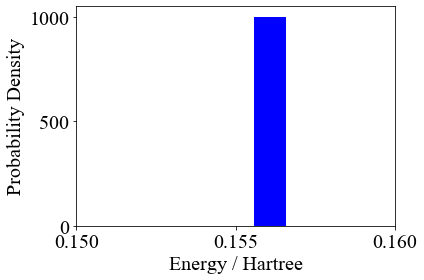

In [44]:
from matplotlib import pyplot
%matplotlib inline


# bins_standard = len(set(E_list_STANDARD_sim))
bins_standard = 1000

# bin_heights_XY, bin_borders_XY, _=pyplot.hist(E_list_SEQ_ROT_XY,
#                                                           bins_standard, alpha=0.7,
#                                                           label='$XY$ terms',
#                                                           color='b',
#                                                           density=False)

bin_heights_Z, bin_borders_Z, _=pyplot.hist(E_list_SEQ_ROT_Z,
                                                          bins_standard, alpha=1,
                                                          label='$Z$ terms',
                                                          color='b',
                                                          density=True)

pyplot.rcParams["font.family"] = "Times New Roman"
pyplot.ylabel('Probability Density', fontsize=20)
pyplot.xlabel('Energy / Hartree', fontsize=20)
pyplot.xticks(np.arange(0.15,0.17,0.005), fontsize=20)
pyplot.xlim((0.15,0.16)) 
pyplot.yticks(np.arange(0,1500,500), fontsize=20)

pyplot.tight_layout()

file_name = 'LiH_SEQ_ROT_Z.jpeg'
pyplot.savefig(file_name, dpi=300,transparent=True,) # edgecolor='black', facecolor='white')
pyplot.show()

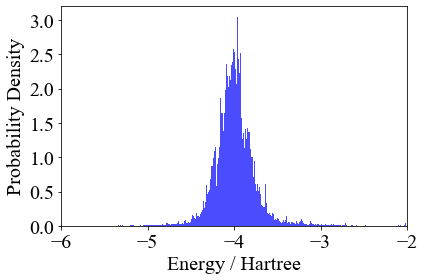

In [42]:
from matplotlib import pyplot
%matplotlib inline


# bins_standard = len(set(E_list_STANDARD_sim))
bins_standard = 1000

bin_heights_XY, bin_borders_XY, _=pyplot.hist(E_list_SEQ_ROT_XY,
                                                          bins_standard, alpha=0.7,
                                                          label='$XY$ terms',
                                                          color='b',
                                                          density=True)

# bin_heights_Z, bin_borders_Z, _=pyplot.hist(E_list_SEQ_ROT_Z,
#                                                           bins_standard, alpha=0.7,
#                                                           label='$Z$ terms',
#                                                           color='r',
#                                                           density=False)

pyplot.rcParams["font.family"] = "Times New Roman"
pyplot.ylabel('Probability Density', fontsize=20)
pyplot.xlabel('Energy / Hartree', fontsize=20)
pyplot.xticks(np.arange(-6,-1,1), fontsize=20)
pyplot.xlim((-6, -2)) 
pyplot.yticks(np.arange(0,3.5,0.5), fontsize=20)

pyplot.tight_layout()

file_name = 'LiH_SEQ_ROT_XY.jpeg'
pyplot.savefig(file_name, dpi=300,transparent=True,) # edgecolor='black', facecolor='white')
pyplot.show()